# Feature Extraction Verification

This notebook audits the core logic in `src/features/feature_extraction.py`.
Assuming the raw data is correct (verified in `notebooks/01`), we now check the transformation of raw signals into meaningful physiological features.

**Objectives:**
1.  **EDA**: Visualizing the decomposition into Phasic (SCR events) and Tonic (SCL baseline) components.
2.  **ECG**: Verifying R-peak detection on the downsampled (35Hz) signal.
3.  **Physiological Features**: Checking if extracted metrics (HRV, Temp Slope, SCR Frequency) show statistical separation between baseline and stress states.

In [1]:
# 1. Imports & Setup
%load_ext autoreload
%autoreload 2

# Standard Library Imports
import sys
import importlib
from pathlib import Path

# Third-Party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project-Specific Imports
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.config import load_config
from src.data.make_dataset import WESADPreprocessor

# Reload critical modules to reflect recent changes
import src.features.feature_extraction
import src.visualization.plots
importlib.reload(src.features.feature_extraction)
importlib.reload(src.visualization.plots)

from src.features.feature_extraction import FeatureExtractor
from src.visualization.plots import (
    set_plot_style, 
    plot_eda_decomposition, 
    plot_ecg_audit, 
    plot_feature_separability, 
    plot_feature_importance_cohens_d, 
    plot_feature_pairplot, 
    plot_correlation_matrix, 
    get_top_discriminative_features,
    plot_temp_audit,
    plot_resp_audit
)

# Apply global configuration
set_plot_style()
config = load_config()
print("Setup Complete.")
print(f"Configuration loaded for: {config['data']['sensor_location']}")

Setup Complete.
Configuration loaded for: chest


In [2]:
# 2. Load Preprocessed Data

preprocessor = WESADPreprocessor()
subject_id = 'S2'

print(f"Loading and processing data for {subject_id}...")
windows = preprocessor.process_subject(subject_id)

print(f"Loaded {len(windows)} windows.")
print(f"Window Structure: {list(windows[0].keys())}")

Loading and processing data for S2...
2026-01-18 19:03:25,525 - src.data.make_dataset - INFO - Loading C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker\data\raw\WESAD\S2\S2.pkl
2026-01-18 19:03:33,264 - src.data.make_dataset - INFO - Subject S2: 71 windows created.
Loaded 71 windows.
Window Structure: ['subject_id', 'label', 'start_idx', 'ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EDA', 'RESP', 'TEMP']


## 3. Audit EDA Processing
We verify the logic used in `FeatureExtractor._process_eda`. 
We replicate the logic here to visualize the Phasic vs Tonic split and SCR peaks.

Selected Audit Window: 0 (Max Range)
Decomposition: 13 SCR peaks detected.


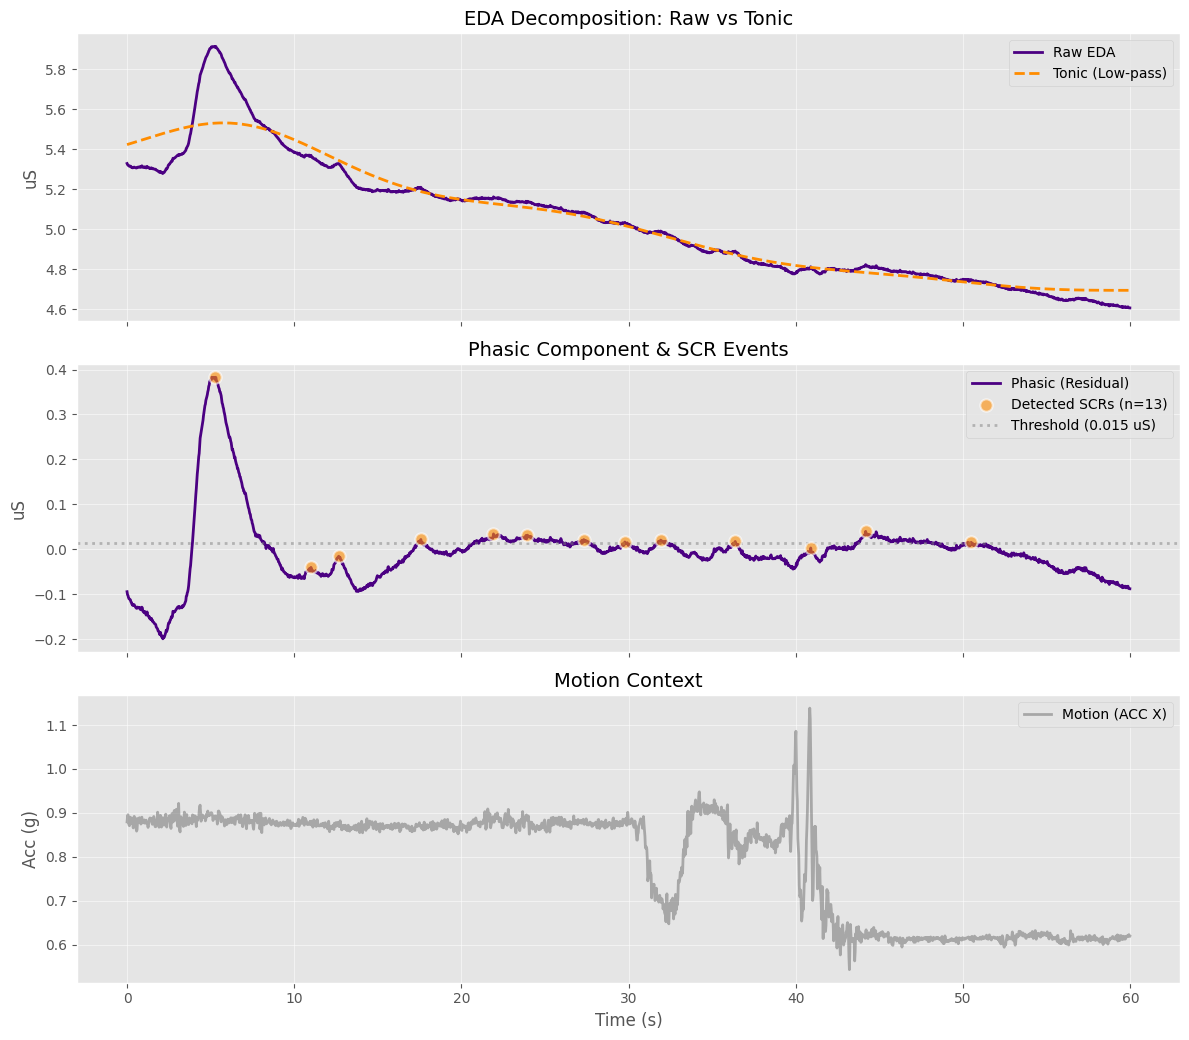

In [3]:
# 3. EDA Processing Audit

# Identify a window with high EDA activity for clear visualization
eda_ranges = [np.max(w['EDA']) - np.min(w['EDA']) for w in windows]
audit_idx = np.argmax(eda_ranges)
window = windows[audit_idx]
print(f"Selected Audit Window: {audit_idx} (Max Range)")

# Extract parameters from config
fs = config['data']['target_sampling_rate']
eda_threshold = config['features']['eda']['scr_threshold']

# Run extraction logic
eda_signal = np.array(window['EDA'])
extractor = FeatureExtractor(config)
tonic, phasic, peaks = extractor.get_eda_components(eda_signal)

print(f"Decomposition: {len(peaks)} SCR peaks detected.")

# Visualize
sensor_loc = config['data'].get('sensor_location', 'chest').upper()
fig = plot_eda_decomposition(
    time_axis=np.arange(len(eda_signal)) / fs,
    raw=eda_signal,
    tonic=tonic,
    phasic=phasic,
    peaks=peaks,
    threshold=eda_threshold,
    motion_signal=np.array(window['ACC_x']),
    save_folder=sensor_loc
)
plt.show()

## 4. Audit ECG Processing
Verify if the simple bandpass + peak detection works reasonably well on the 35Hz downsampled ECG.

R-Peak Detection: Found 81 peaks.
Adaptive Threshold Used: 0.1869 mV


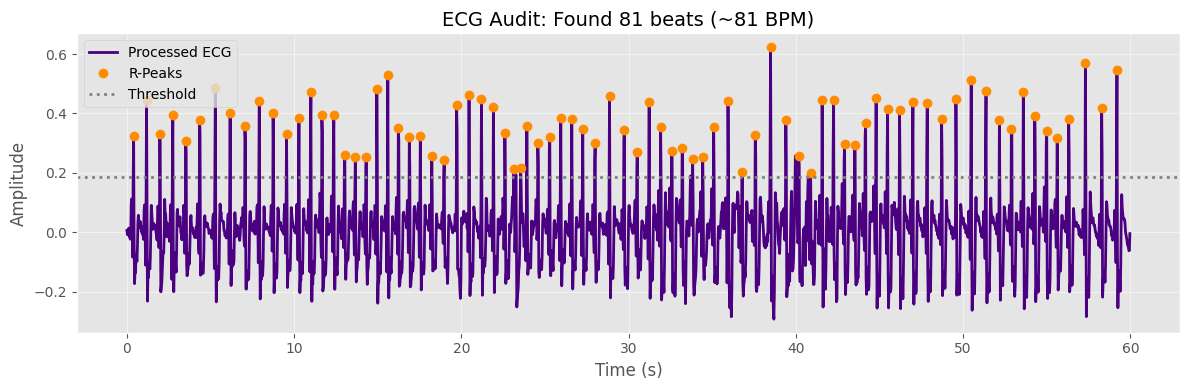

In [4]:
# 4. ECG Processing Audit

ecg_signal = np.array(window['ECG'])
fs = config['data']['target_sampling_rate']

# Run extraction logic
extractor = FeatureExtractor(config)
clean_ecg, peaks, threshold_used = extractor.get_ecg_peaks(ecg_signal)

print(f"R-Peak Detection: Found {len(peaks)} peaks.")
print(f"Adaptive Threshold Used: {threshold_used:.4f} mV")

# Visualize
sensor_loc = config['data'].get('sensor_location', 'chest').upper()
fig = plot_ecg_audit(
    time_axis=np.arange(len(ecg_signal)) / fs,
    clean_ecg=clean_ecg, 
    peaks=peaks,
    threshold=threshold_used,
    save_folder=sensor_loc
)
plt.show()

## 5. Audit Temperature & Respiration
We verify:
1.  **Temperature Slope**: Correlates with stress (skin temperature often drops initially during acute stress).
2.  **Respiration Rate**: Derived from the chest strap's respiration sensor.

--- Temperature Audit ---


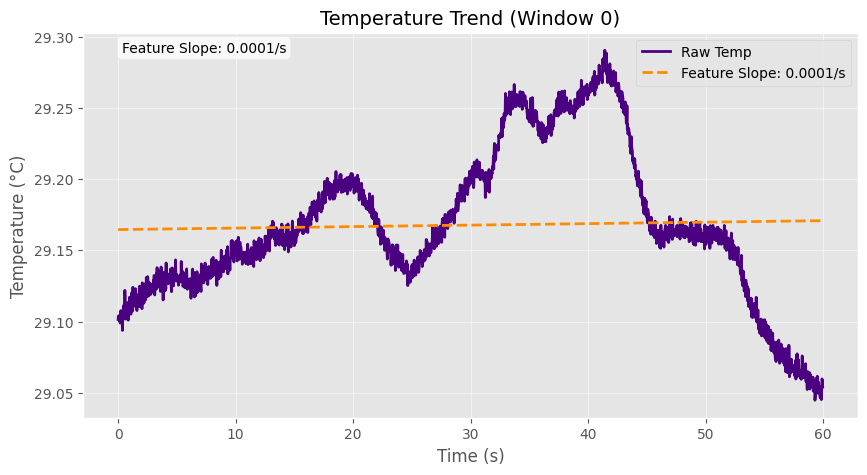

--- Respiration Audit ---


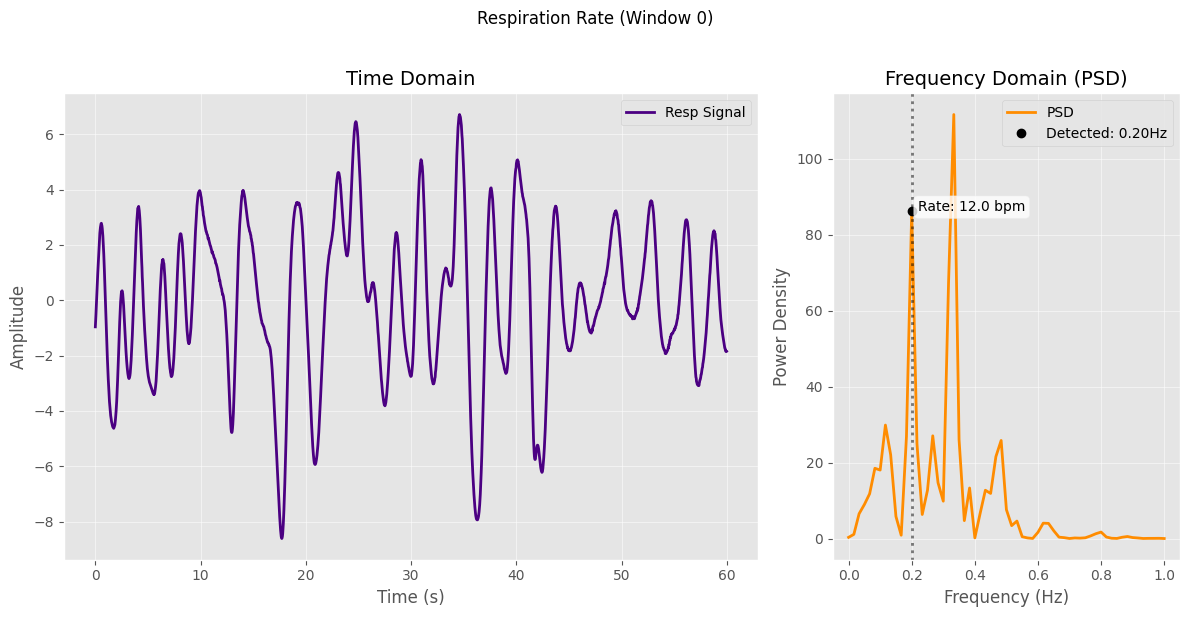

In [5]:
# 5. Temperature & Respiration Audit

sensor_loc = config['data'].get('sensor_location', 'chest').upper()

# --- Temperature Audit ---
print("--- Temperature Audit ---")
temp_signal = np.array(window['TEMP'])
# Compute feature
feats_temp = extractor._process_temp(temp_signal)
slope_val = feats_temp['temp_slope']

fig_temp = plot_temp_audit(
    time_axis=np.arange(len(temp_signal)) / fs,
    temp_signal=temp_signal,
    slope=slope_val,
    title=f"Temperature Trend (Window {audit_idx})",
    save_folder=sensor_loc
)
plt.show()

# --- Respiration Audit ---
print("--- Respiration Audit ---")
if 'RESP' in window:
    resp_signal = np.array(window['RESP'])
    # Compute feature
    feats_resp = extractor._process_resp(resp_signal)
    detected_hz = feats_resp['resp_rate_Hz']
    
    fig_resp = plot_resp_audit(
        time_axis=np.arange(len(resp_signal)) / fs,
        resp_signal=resp_signal,
        fs=fs,
        detected_rate=detected_hz,
        title=f"Respiration Rate (Window {audit_idx})",
        save_folder=sensor_loc
    )
    plt.show()
else:
    print("Warning: No RESP signal found in window.")

## 6. Generate Full Feature Vector
Run the `FeatureExtractor` on a single window to inspect the final output format (Pandas Series).
This confirms the integration of all modalities (EDA, ECG, TEMP, RESP, ACC).

In [6]:
# 6. Feature Vector Generation

# Run full feature extraction pipeline on the single window
features = extractor.extract_features(window)
feat_series = pd.Series(features)

print("--- Extracted Feature Vector ---")
print(feat_series)

# Integrity Check
if feat_series.isnull().any():
    print(f"\nWARNING: NaNs detected in features: {feat_series[feat_series.isnull()].index.tolist()}")
else:
    print("\nSUCCESS: Feature vector is complete (No NaNs).")

--- Extracted Feature Vector ---
eda_mean              5.037618
eda_std               0.302151
eda_tonic_mean        5.042005
eda_phasic_std        0.079035
eda_range             1.305083
eda_acc_scr_count    13.000000
temp_mean            29.167706
temp_std              0.053449
temp_min             29.044714
temp_max             29.290561
temp_slope            0.000104
acc_std               0.024116
acc_range             0.493602
acc_energy            0.000582
ecg_hr_bpm           81.632653
ecg_rmssd             0.077216
ecg_sdnn              0.114105
resp_mean            -0.041047
resp_std              2.872213
resp_range           15.325497
resp_rate_Hz          0.200000
resp_rate_bpm        12.000000
dtype: float64

SUCCESS: Feature vector is complete (No NaNs).


## 7. Feature Separability Analysis
We extract features for a subset of windows (Subject S2) to visually verify discriminatory power.
**Violin Plots** are used to compare the distribution of each feature across 'Baseline' (1) and 'Stress' (2).
**Classification Expectation**: We expect significant shifts in features like `EDA_scr_peaks_mean` or `ECG_hr_mean`.

Extracting features for first 1000 windows...
Features Analyzing: 22


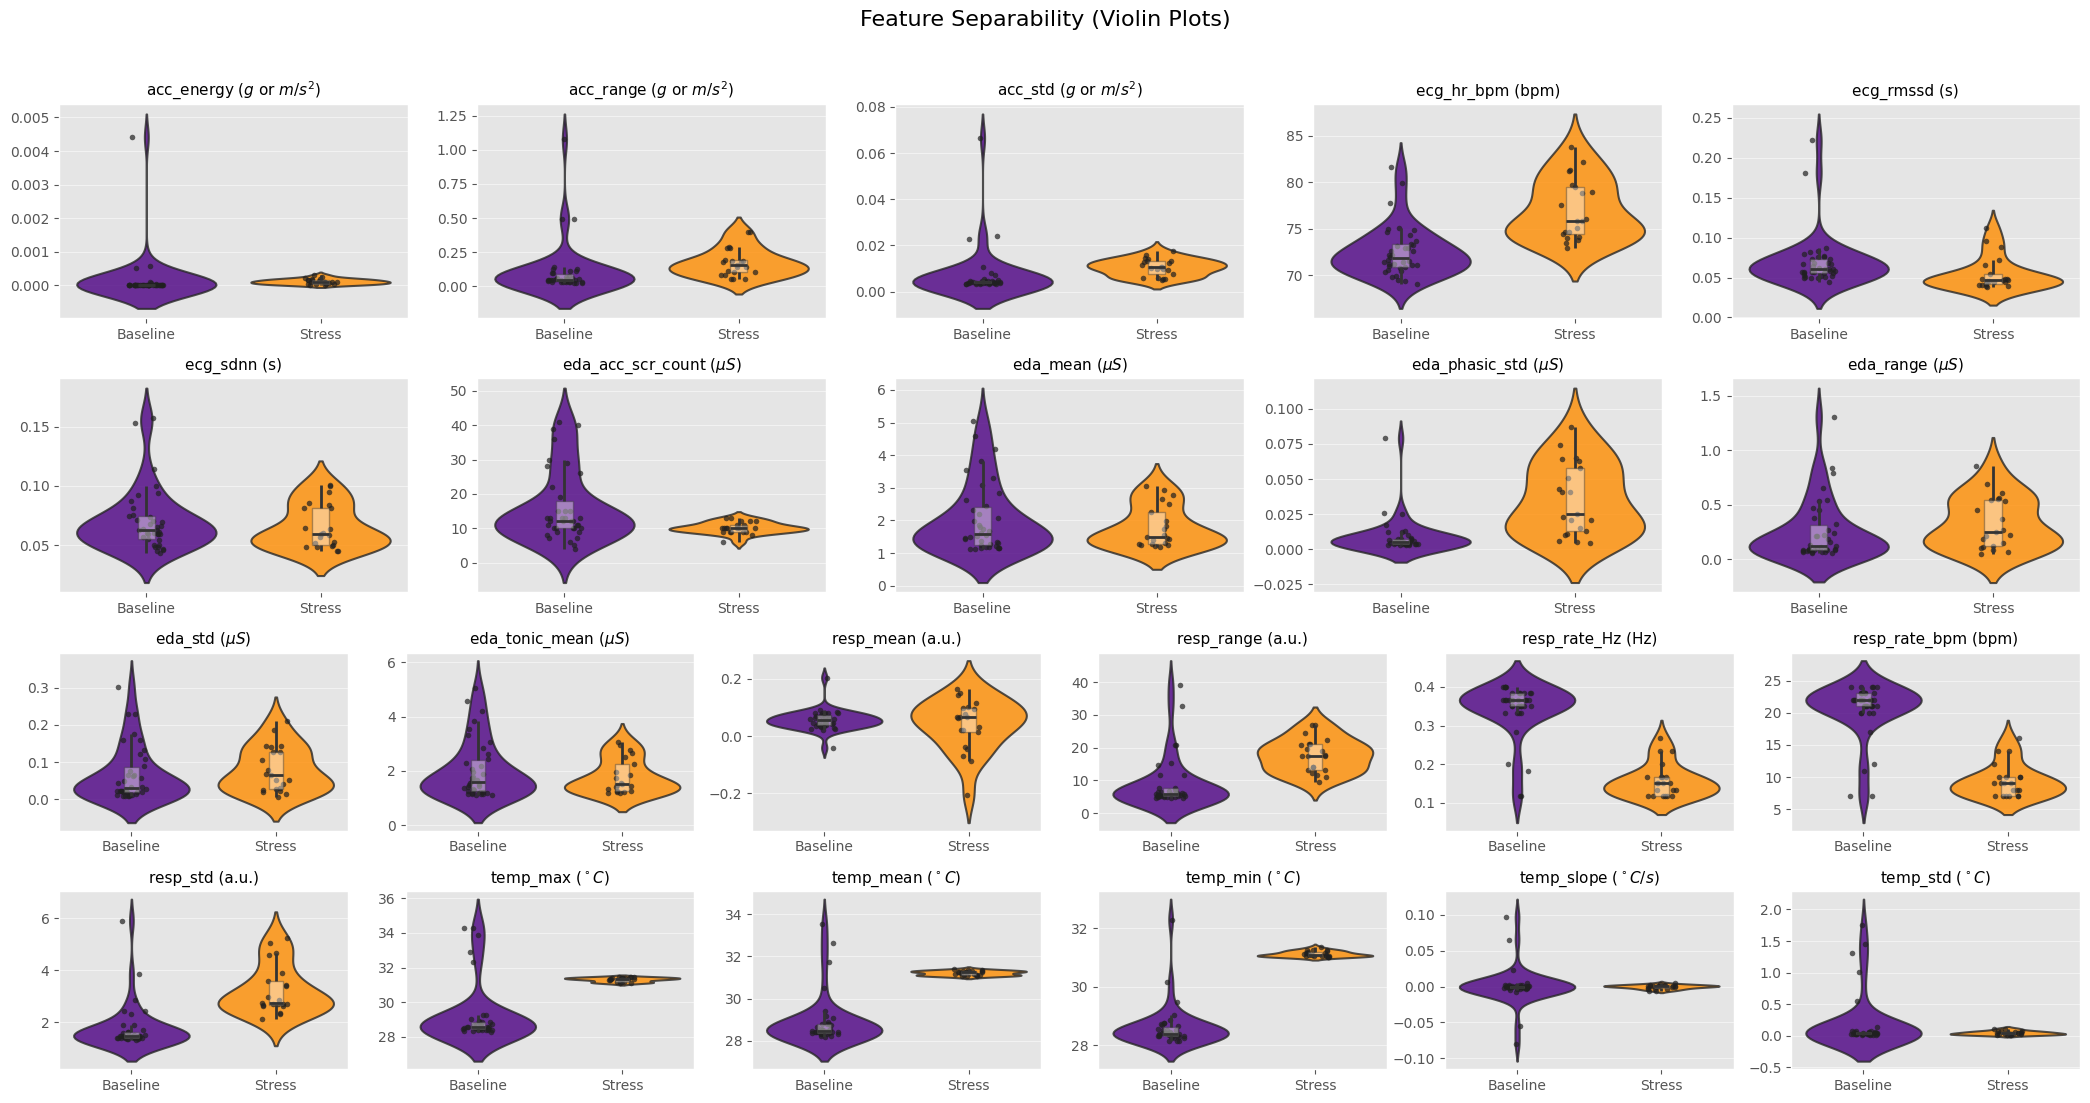

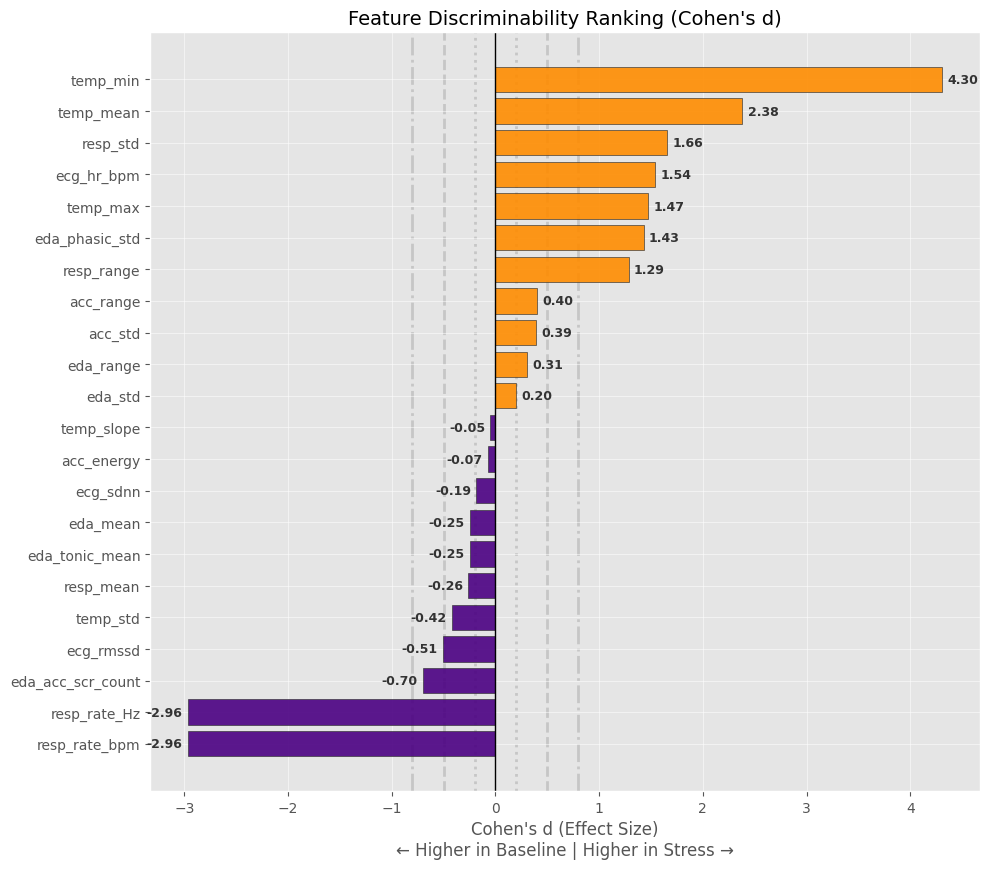

In [7]:
# 7. Batch Discriminability Analysis

# Limit the number of windows for rapid interactive visualization
AUDIT_LIMIT = 1000
print(f"Extracting features for first {AUDIT_LIMIT} windows...")

audit_windows = windows[:AUDIT_LIMIT]
data = []
for w in audit_windows:
    feats = extractor.extract_features(w)
    feats['label'] = w['label']
    data.append(feats)

df = pd.DataFrame(data)

# Filter for Binary Classification (Baseline=1 vs Stress=2)
df_filtered = df[df['label'].isin([1, 2])].copy()
df_filtered['label_name'] = df_filtered['label'].map({1: 'Baseline', 2: 'Stress'})

# Prepare Plot Columns (exclude metadata)
plot_cols = [c for c in df_filtered.columns if c not in ['label', 'label_name']]
plot_cols.sort()
print(f"Features Analyzing: {len(plot_cols)}")

sensor_loc = config['data'].get('sensor_location', 'chest').upper()

# 1. Violin Plots (Separability)
fig_violins = plot_feature_separability(
    df=df_filtered,
    feature_cols=plot_cols,
    label_col='label_name',
    title="Feature Separability (Violin Plots)",
    save_folder=sensor_loc
)
plt.show()

# 2. Cohen's d (Effect Size)
fig_cohen = plot_feature_importance_cohens_d(
    df=df_filtered,
    feature_cols=plot_cols,
    label_col='label_name',
    class_1='Stress',
    class_0='Baseline',
    title="Feature Discriminability Ranking (Cohen's d)",
    save_folder=sensor_loc
)
plt.show()

## 8. Feature Correlation & Pair Plot
We visualize the relationships between the "Top 6" most discriminative features (based on Effect Size) to understand redundancy and multivariate separability.
This helps anticipate multicollinearity issues for linear models.

Top Features Selected for Pair Plot: ['temp_min', 'resp_rate_bpm', 'resp_std', 'ecg_hr_bpm', 'eda_phasic_std', 'eda_acc_scr_count']


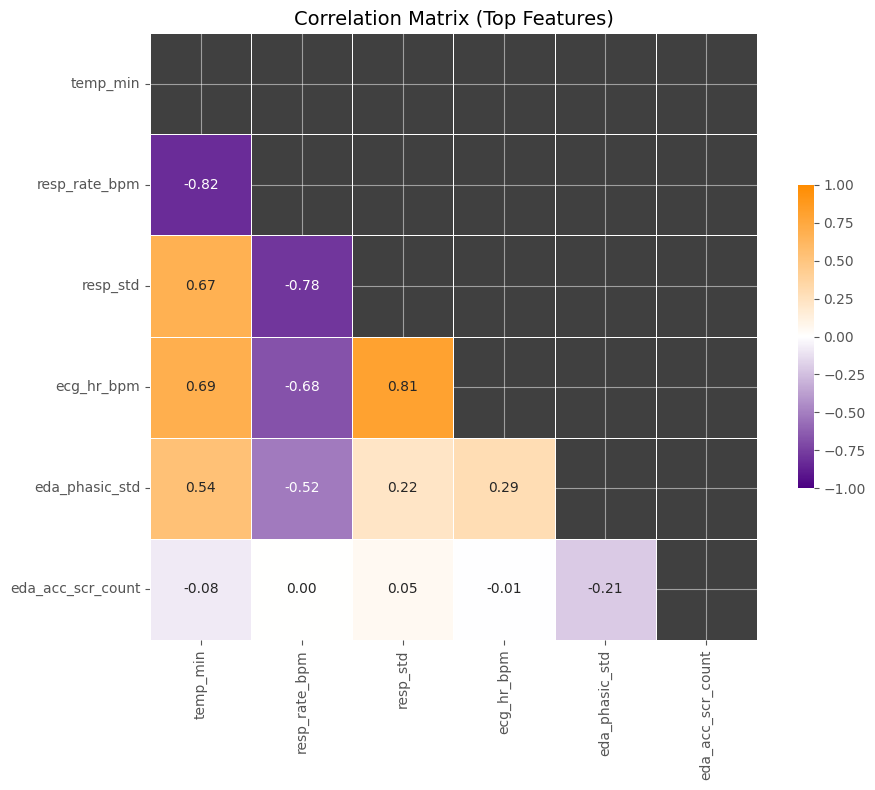

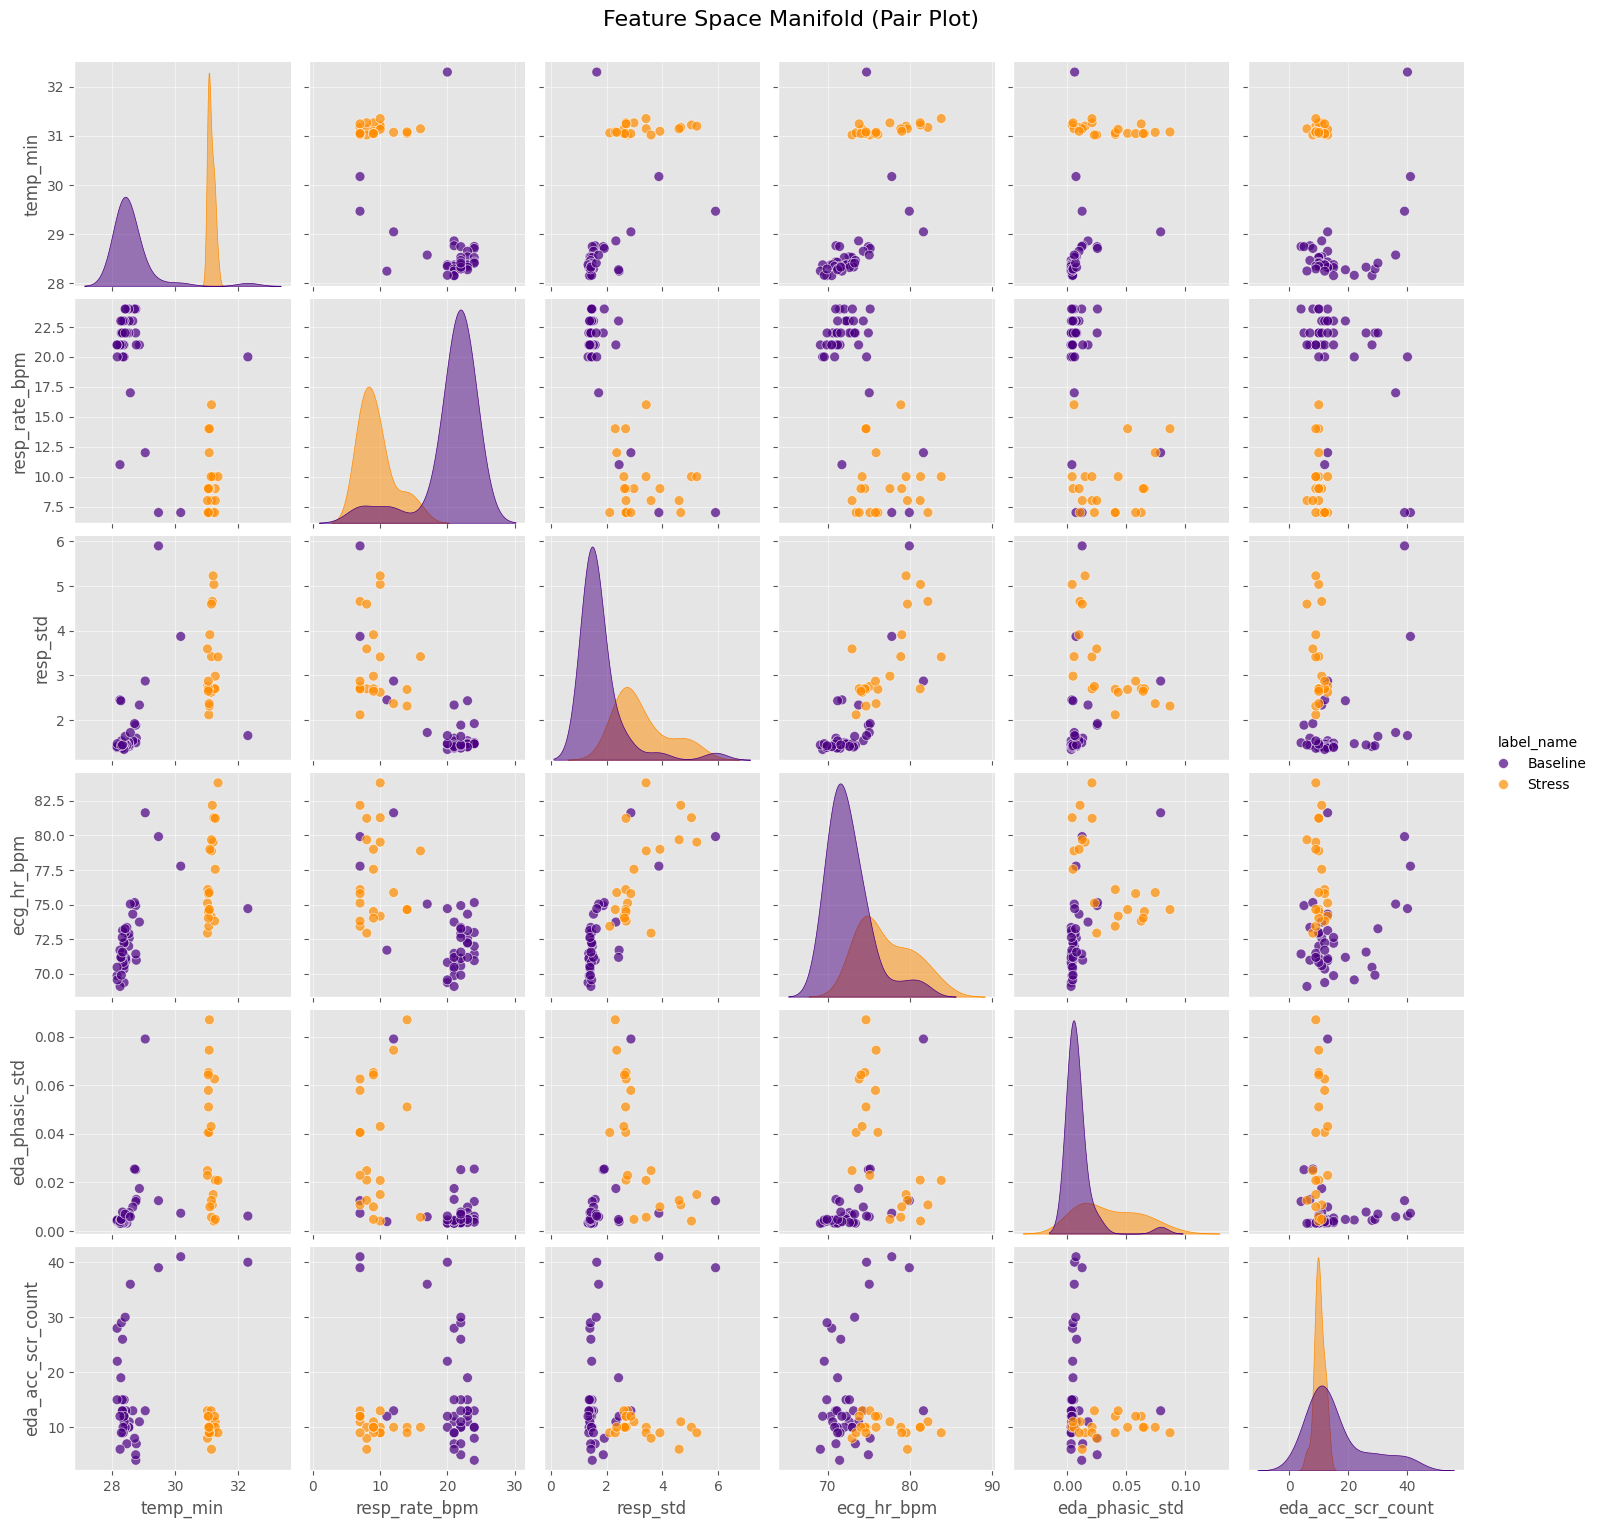

In [8]:
# 8. Multivariate Relationship Analysis

# Select top discriminative features automatically
top_features = get_top_discriminative_features(
    df_filtered, 
    plot_cols, 
    label_col='label_name',
    n=6
)
print(f"Top Features Selected for Pair Plot: {top_features}")

sensor_loc = config['data'].get('sensor_location', 'chest').upper()

# 1. Correlation Matrix
fig_corr = plot_correlation_matrix(
    df=df_filtered,
    feature_cols=top_features,
    title="Correlation Matrix (Top Features)",
    save_folder=sensor_loc
)
plt.show()

# 2. Pairwise Scatter Plots
g = plot_feature_pairplot(
    df=df_filtered,
    feature_cols=top_features,
    label_col='label_name',
    title="Feature Space Manifold (Pair Plot)",
    save_folder=sensor_loc
)
plt.show()

## 9. Conclusion
The feature extraction logic appears robust visually. The boxplots in Section 7 provide confirmatory evidence that the physiological states are strictly discriminable using our custom feature set.
Next Step: Train Baseline Models (`notebooks/03`).